In [219]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'  #默认为'last'
import warnings 
warnings.filterwarnings('ignore')

In [220]:
import pandas as pd
import numpy
from sklearn.tree import DecisionTreeClassifier
from sklearn import neighbors
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance
from sklearn import metrics
from sklearn import preprocessing
%matplotlib inline

In [221]:
train_set = pd.read_csv("./train_set.csv")
train_set = pd.DataFrame(train_set)

test_set = pd.read_csv("./test_set.csv")
test_set = pd.DataFrame(test_set)

data = pd.concat([train_set,test_set])
data
# def preprocess(dataset):
    
#     vec = DictVectorizer(sparse=False)
#     dataset = vec.fit_transform(dataset.to_dict(orient="record"))
#     dataset = pd.DataFrame(dataset)
#     dataset.columns = vec.feature_names_
#     return dataset

# train_set = preprocess(train_set)

,ID,age,balance,campaign,contact,day,default,duration,education,housing,job,loan,marital,month,pdays,poutcome,previous,y
0,1,43,291,2,unknown,9,no,150,tertiary,yes,management,no,married,may,-1,unknown,0,0.0
1,2,42,5076,1,cellular,7,no,99,primary,yes,technician,no,divorced,apr,251,other,2,0.0
2,3,47,104,2,cellular,14,no,77,secondary,yes,admin.,yes,married,jul,-1,unknown,0,0.0
3,4,28,-994,2,cellular,18,no,174,secondary,yes,management,yes,single,jul,-1,unknown,0,0.0
4,5,42,2974,5,unknown,21,no,187,secondary,yes,technician,no,divorced,may,-1,unknown,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10847,36165,29,54,3,unknown,26,no,257,tertiary,yes,management,yes,single,may,-1,unknown,0,NaN
10848,36166,35,674,2,cellular,8,no,87,secondary,no,management,no,married,aug,-1,unknown,0,NaN
10849,36167,38,435,2,unknown,23,no,193,secondary,yes,services,no,married,may,-1,unknown,0,NaN
10850,36168,41,783,3,cellular,14,no,135,secondary,yes,admin.,yes,divorced,may,363,failure,2,NaN


In [222]:
def feature_count(data, features):
    feature_name = 'count'
    for i in features:
        feature_name += '_' + i
    temp = data.groupby(features).size().reset_index().rename(columns={0: feature_name})
    data = data.merge(temp, 'left', on=features)
    return data,feature_name


In [258]:
feature=data.columns.tolist()
feature.remove('ID')
feature.remove('y')
#离散值和连续值分开处理
sparse_feature= ['campaign','contact','default','education','housing','job','loan','marital','month','poutcome']
dense_feature=list(set(feature)-set(sparse_feature))


In [224]:
#举例
# data.groupby(['day','month','campaign']).size().reset_index()

In [259]:
ll=[]
# 离散特征和时间一起统计
for f in['campaign', 'contact','default','education','housing','job','loan','marital','poutcome']:
    data,_=feature_count(data,['day','month',f])
    ll.append(_)
data

,ID,age,balance,campaign,contact,day,default,duration,education,housing,...,poutcome_balance_std,count_day_month_campaign_y,count_day_month_contact_y,count_day_month_default_y,count_day_month_education_y,count_day_month_housing_y,count_day_month_job_y,count_day_month_loan_y,count_day_month_marital_y,count_day_month_poutcome_y
0,1,43,291,2,unknown,9,no,150,tertiary,yes,...,3110.872628,112,338,326,67,303,46,292,180,338
1,2,42,5076,1,cellular,7,no,99,primary,yes,...,3520.820623,41,68,71,9,54,12,62,9,7
2,3,47,104,2,cellular,14,no,77,secondary,yes,...,3110.872628,78,204,230,147,138,30,64,166,235
3,4,28,-994,2,cellular,18,no,174,secondary,yes,...,3110.872628,49,194,194,110,130,60,72,53,206
4,5,42,2974,5,unknown,21,no,187,secondary,yes,...,3110.872628,15,357,361,213,326,63,313,24,358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36164,36165,29,54,3,unknown,26,no,257,tertiary,yes,...,3110.872628,53,336,448,116,331,83,73,124,408
36165,36166,35,674,2,cellular,8,no,87,secondary,no,...,3110.872628,140,261,263,97,217,96,233,190,265
36166,36167,38,435,2,unknown,23,no,193,secondary,yes,...,3110.872628,81,339,332,203,307,36,290,203,339
36167,36168,41,783,3,cellular,14,no,135,secondary,yes,...,2681.009145,88,411,802,490,730,107,101,99,130


In [226]:
def get_new_columns(name,aggs):
    l=[]
    for k in aggs.keys():
        for agg in aggs[k]:
            if str(type(agg))=="<class 'function'>":
                l.append(name + '_' + k + '_' + 'other')
            else:
                l.append(name + '_' + k + '_' + agg)
    return l

In [193]:
#举例
'''
首先按照一个离散特征分组,计算一个离散特征和其他所有特征的关系,如果其他特征是离散特征,计算count和nunique,如果是连续特征,计算mean等
# https://blog.csdn.net/u012706792/article/details/80892510

'''
d = "campaign"
aggs={}
for s in sparse_feature:
    aggs[s]=['count','nunique']
for den in dense_feature:
    aggs[den]=['mean','max','min','std']
t = aggs.pop(d)
temp=data.groupby(d).agg(aggs).reset_index()
# temp=data.groupby(d).size().reset_index()
temp.columns=[d]+get_new_columns(d,aggs)
# data=pd.merge(data,temp,on=d,how='left')
temp

'\n首先按照一个离散特征分组,计算一个离散特征和其他所有特征的关系,如果其他特征是离散特征,计算count和nunique,如果是连续特征,计算mean等\n# https://blog.csdn.net/u012706792/article/details/80892510\n\n'

,campaign,campaign_contact_count,campaign_contact_nunique,campaign_default_count,campaign_default_nunique,campaign_education_count,campaign_education_nunique,campaign_housing_count,campaign_housing_nunique,campaign_job_count,...,campaign_pdays_min,campaign_pdays_std,campaign_age_mean,campaign_age_max,campaign_age_min,campaign_age_std,campaign_balance_mean,campaign_balance_max,campaign_balance_min,campaign_balance_std
0,1,14032,3,14032,2,14032,4,14032,2,14032,...,-1,109.250736,40.725912,95,18,11.100849,1422.397377,102127,-6847,3223.867325
1,2,9989,3,9989,2,9989,4,9989,2,9989,...,-1,98.632177,40.943438,93,18,10.508131,1371.114025,66721,-1965,3017.464815
2,3,4427,3,4427,2,4427,4,4427,2,4427,...,-1,97.386213,40.895866,90,18,10.396554,1366.242150,66653,-8019,2994.281445
3,4,2829,3,2829,2,2829,4,2829,2,2829,...,-1,86.783098,41.703075,92,18,10.189724,1230.320961,64343,-1737,2702.871756
4,5,1391,3,1391,2,1391,4,1391,2,1391,...,-1,93.601105,41.365924,89,19,10.674071,1269.248023,98417,-1882,3555.853303
5,6,1036,3,1036,2,1036,4,1036,2,1036,...,-1,87.096961,41.944015,82,19,9.898360,1336.424710,43074,-4057,2993.296542
6,7,580,3,580,2,580,4,580,2,580,...,-1,84.624926,41.539655,82,23,9.900026,1256.955172,31472,-1598,2617.527927
7,8,421,3,421,2,421,4,421,2,421,...,-1,79.414961,41.912114,80,22,9.310228,1363.256532,26765,-1531,2937.376920
8,9,268,3,268,2,268,4,268,2,268,...,-1,75.396861,40.440299,79,23,9.433394,1803.861940,34646,-803,4103.692700
9,10,217,3,217,2,217,4,217,2,217,...,-1,46.662967,41.857143,73,23,9.457158,1105.981567,14530,-1313,2133.384437


In [227]:
for d in tqdm(sparse_feature):
    aggs={}
    for s in sparse_feature:
        aggs[s]=['count','nunique']
    for den in dense_feature:
        aggs[den]=['mean','max','min','std']
    t = aggs.pop(d)
    temp=data.groupby(d).agg(aggs).reset_index()
    temp.columns=[d]+get_new_columns(d,aggs)
    data=pd.merge(data,temp,on=d,how='left')
data.head()

,ID,age,balance,campaign,contact,day,default,duration,education,housing,...,poutcome_pdays_min,poutcome_pdays_std,poutcome_age_mean,poutcome_age_max,poutcome_age_min,poutcome_age_std,poutcome_balance_mean,poutcome_balance_max,poutcome_balance_min,poutcome_balance_std
0,1,43,291,2,unknown,9,no,150,tertiary,yes,...,-1,4.225828,40.958787,95,18,10.448508,1328.649117,102127,-8019,3110.872628
1,2,42,5076,1,cellular,7,no,99,primary,yes,...,1,123.825801,39.932881,89,18,11.297997,1504.440678,81204,-1882,3520.820623
2,3,47,104,2,cellular,14,no,77,secondary,yes,...,-1,4.225828,40.958787,95,18,10.448508,1328.649117,102127,-8019,3110.872628
3,4,28,-994,2,cellular,18,no,174,secondary,yes,...,-1,4.225828,40.958787,95,18,10.448508,1328.649117,102127,-8019,3110.872628
4,5,42,2974,5,unknown,21,no,187,secondary,yes,...,-1,4.225828,40.958787,95,18,10.448508,1328.649117,102127,-8019,3110.872628


In [ ]:


# dataset = preprocess(train_set)

# x_train = dataset.iloc[:,:-1].copy()
# y_train = dataset.iloc[:,-1].copy()
    
# for i in x_train.columns:
#     x_train.loc[:,i] = (x_train.loc[:,i] - x_train.loc[:,i].mean())/x_train.loc[:,i].std()

# x_train

In [ ]:
# x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=33)
# x_train
# y_train.shape

In [228]:
test = data.copy()
for s in ['campaign','contact','default','education','housing','job','loan','marital','month','poutcome']:
    test=pd.concat([test,pd.get_dummies(data[s],prefix=s+'_')],axis=1)
    test.drop(s,axis=1,inplace=True)


In [229]:
train_set = test[test['y'].notnull()]
test_set = test[test['y'].isnull()]
y_train = train_set['y']

trainset_columns=train_set.columns.tolist()
trainset_columns.remove('ID')
trainset_columns.remove('y')

In [246]:
chosen_columns=['age',
 'balance',
 'day',
 'duration',
 'pdays',
 'previous',
 'campaign_contact_count',
 'campaign_duration_max',
 'campaign_duration_std',
 'campaign_age_max',
 'campaign_day_std',
 'campaign_balance_min',
 'campaign_previous_std',
 'contact_campaign_count',
 'contact_duration_max',
 'education_campaign_count',
 'education_duration_mean',
 'housing_campaign_count',
 'job_campaign_count',
 'job_duration_mean',
 'job_duration_max',
 'job_age_mean',
 'job_age_max',
 'job_age_std',
 'job_day_mean',
 'job_day_std',
 'job_pdays_max',
 'job_previous_mean',
 'loan_campaign_count',
 'marital_campaign_count',
 'month_campaign_count',
 'month_campaign_nunique',
 'month_duration_mean',
 'month_age_mean',
 'month_age_max',
 'month_day_mean',
 'month_day_std',
 'month_pdays_mean',
 'month_pdays_max',
 'month_pdays_std',
 'month_balance_mean',
 'month_previous_max',
 'month_previous_std',
 'poutcome_campaign_count',
 'count_day_month_campaign',
 'count_day_month_contact',
 'count_day_month_default',
 'count_day_month_education',
 'count_day_month_housing',
 'count_day_month_job',
 'count_day_month_loan',
 'count_day_month_marital',
 'count_day_month_poutcome']

x_train = train_set[chosen_columns]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

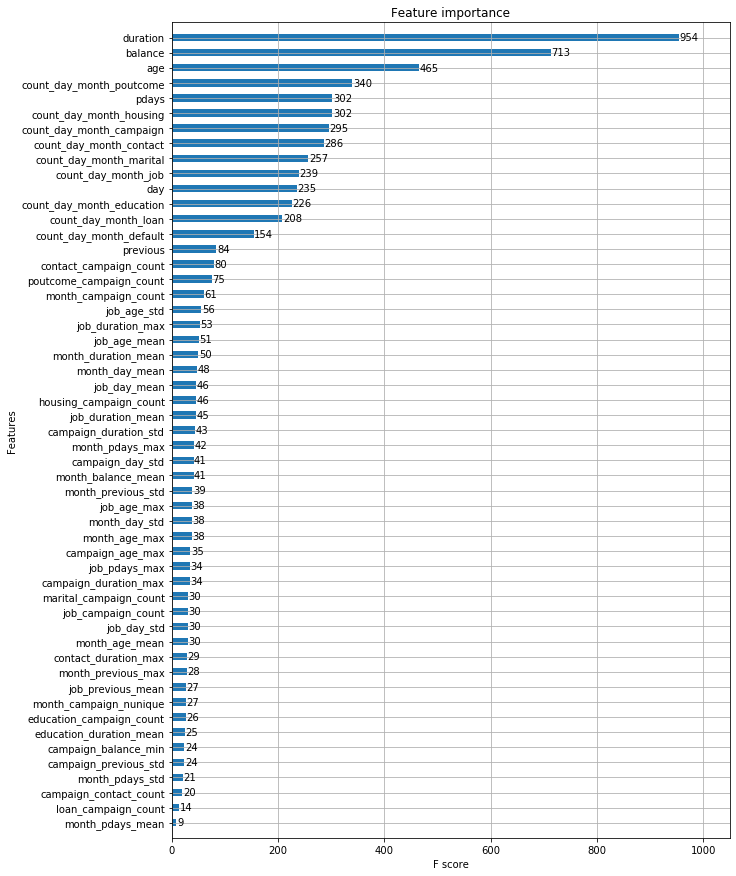

'\n选择一个相对来说稍微高一点的learning rate。一般默认的值是0.1，不过针对不同的问题，0.05到0.2之间都可以\n决定当前learning rate下最优的决定树数量。它的值应该在40-70之间。记得选择一个你的电脑还能快速运行的值，因为之后这些树会用来做很多测试和调参。\n接着调节树参数来调整learning rate和树的数量。我们可以选择不同的参数来定义一个决定树，后面会有这方面的例子\n降低learning rate，同时会增加相应的决定树数量使得模型更加稳健\n\n'

In [233]:
model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=1000)
model.fit(x_train, y_train)
fig, ax = plt.subplots(figsize=(10, 15))
plot_importance(model, height=0.5, max_num_features=64, ax=ax)
plt.show()
'''
选择一个相对来说稍微高一点的learning rate。一般默认的值是0.1，不过针对不同的问题，0.05到0.2之间都可以
决定当前learning rate下最优的决定树数量。它的值应该在40-70之间。记得选择一个你的电脑还能快速运行的值，因为之后这些树会用来做很多测试和调参。
接着调节树参数来调整learning rate和树的数量。我们可以选择不同的参数来定义一个决定树，后面会有这方面的例子
降低learning rate，同时会增加相应的决定树数量使得模型更加稳健

'''

In [234]:
def modelfit(alg, X, Y, useTrainCV=True, cv_folds=10, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X.values, label=Y.values)
        cvresult = xgb.cv(xgb_param,
                          xgtrain,
                          num_boost_round=alg.get_params()['n_estimators'],
                          nfold=cv_folds,
                          metrics='auc',
                          early_stopping_rounds=early_stopping_rounds,
                          verbose_eval=False)
        alg.set_params(n_estimators=cvresult.shape[0])

    #Fit the algorithm on the data
    alg.fit(X, Y, eval_metric='auc')

    #Predict training set:
    dtrain_predictions = alg.predict(X)
    dtrain_predprob = alg.predict_proba(X)[:, 1]

    #Print model report:
    print("\nModel Report")
    print("Best Num Of Tree:{}".format(cvresult.shape[0]))
    print("Accuracy : %.4g" %
          metrics.accuracy_score(Y.values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(Y, dtrain_predprob))

    feat_imp = pd.Series(
        alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


Model Report
Best Num Of Tree:120
Accuracy : 0.9415
AUC Score (Train): 0.968497


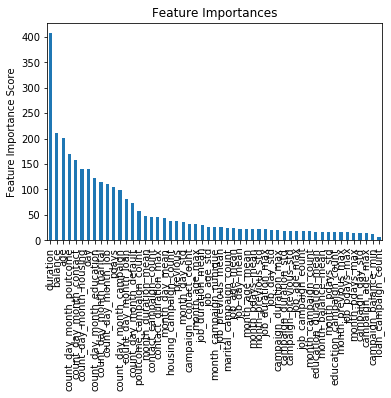

In [235]:
xgb1 = XGBClassifier(learning_rate=0.1,
                     n_estimators=1000,
                     max_depth=5,
                     min_child_weight=1,
                     gamma=0,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     objective='binary:logistic',
                     nthread=4,
                     scale_pos_weight=1,
                     seed=27)
# 得到Best Num Of Tree
modelfit(xgb1, x_train, y_train)

In [236]:
param_test1 = {
    'max_depth': range(3, 10, 2),
    'min_child_weight': range(1, 6, 2)
}
gsearch1 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1,
                                                n_estimators=120,
                                                max_depth=5,
                                                min_child_weight=2,
                                                gamma=0,
                                                subsample=0.8,
                                                colsample_bytree=0.8,
                                                objective='binary:logistic',
                                                nthread=4,
                                                scale_pos_weight=1,
                                                seed=27),
                        param_grid=param_test1,
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False,
                        cv=5)
gsearch1.fit(x_train, y_train)

res1 = gsearch1.cv_results_
res2 = gsearch1.best_params_
res3 = gsearch1.best_score_

print(res1)
print(res2)
print(res3)
with open("./a.txt", "w") as f:
    ans = "grid_scores_:" + str(res1) + "\n best_params_:" + str(
        res2) + "\n best_score_:" + str(res3)
    f.write(ans)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=5, min_child_weight=2,
                                     missing=None, n_estimators=120, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.8, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 6, 2)},
             pre_dispatch='2*n_jobs', refit=True, retur

{'mean_fit_time': array([ 5.83120198,  7.11576581,  6.32528076, 10.96766162, 10.1420711 ,
        9.84936857, 14.96834488, 14.30373712, 12.96372256, 18.77921238,
       17.95386891, 13.72388964]), 'std_fit_time': array([0.47635541, 0.24168003, 0.5051206 , 0.2412454 , 0.40058114,
       0.33591767, 0.87515837, 0.31573463, 0.44287794, 1.0343951 ,
       0.43955521, 2.55099604]), 'mean_score_time': array([0.04408598, 0.08377724, 0.04727645, 0.04388332, 0.04368463,
       0.0447824 , 0.05265937, 0.04348211, 0.05534778, 0.05477786,
       0.07160902, 0.05066557]), 'std_score_time': array([0.00677438, 0.08794275, 0.01267436, 0.00450454, 0.00116334,
       0.0069274 , 0.01104147, 0.00502804, 0.022193  , 0.00927687,
       0.02012914, 0.01298003]), 'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False],
       fill_value='?',
            dtype=object), '

3242

In [238]:
param_test2 = {
    'max_depth': [4, 5, 6, 7, 8],
    'min_child_weight': [4, 5, 6, 7, 8]
}
gsearch2 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1,
                                                n_estimators=120,
                                                max_depth=5,
                                                min_child_weight=5,
                                                gamma=0,
                                                subsample=0.8,
                                                colsample_bytree=0.8,
                                                objective='binary:logistic',
                                                nthread=4,
                                                scale_pos_weight=1,
                                                seed=27),
                        param_grid=param_test2,
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False,
                        cv=5)
gsearch2.fit(x_train, y_train)
res1 = gsearch2.cv_results_
res2 = gsearch2.best_params_
res3 = gsearch2.best_score_
print(res1)
print(res2)
print(res3)
with open("./a2.txt", "w") as f:
    ans = "grid_scores_:" + str(res1) + "\n best_params_:" + str(
        res2) + "\n best_score_:" + str(res3)
    f.write(ans)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=5, min_child_weight=5,
                                     missing=None, n_estimators=120, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.8, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'min_child_weight': [4, 5, 6, 7, 8]},
             pre_dispatch='2*n_jobs', refit=True, retu

{'mean_fit_time': array([ 9.09387684,  6.83910356,  6.8648376 ,  6.83970256,  6.31610346,
        7.90346069,  8.95763941,  9.09367366,  8.41349826,  7.94057617,
       11.74159217, 11.99750738, 10.54299808, 10.16858706,  9.37392311,
       11.40468903, 11.32989383, 11.14618549, 12.62303348, 14.30134621,
       14.15473423, 14.52654247, 14.34983053, 14.8840322 , 12.13115106]), 'std_fit_time': array([1.19302765, 0.14492957, 0.14894356, 0.06365031, 0.30577673,
       0.35470892, 0.45346419, 0.1191353 , 0.0906817 , 0.27085605,
       0.85149977, 0.42753592, 0.25950091, 0.1104524 , 0.21148451,
       0.16851292, 0.23441377, 0.26111848, 1.14716889, 0.58135118,
       0.3743515 , 0.17312141, 0.3389115 , 0.2855079 , 2.89065873]), 'mean_score_time': array([0.06183271, 0.04089293, 0.04268651, 0.0384973 , 0.03690281,
       0.03869548, 0.04288516, 0.03969388, 0.04089103, 0.03829465,
       0.05126395, 0.06881652, 0.04368429, 0.0410903 , 0.03490849,
       0.03869662, 0.03789849, 0.03809948, 0.03

6092

In [239]:
param_test3 = {'gamma': [i / 10.0 for i in range(0, 5)]}
gsearch3 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1,
                                                n_estimators=120,
                                                max_depth=5,
                                                min_child_weight=6,
                                                gamma=0,
                                                subsample=0.8,
                                                colsample_bytree=0.8,
                                                objective='binary:logistic',
                                                nthread=4,
                                                scale_pos_weight=1,
                                                seed=27),
                        param_grid=param_test3,
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False,
                        cv=5)

gsearch3.fit(x_train, y_train)
res1 = gsearch3.cv_results_
res2 = gsearch3.best_params_
res3 = gsearch3.best_score_
print(res1)
print(res2)
print(res3)
with open("./a3.txt", "w") as f:
    ans = "grid_scores_:" + str(res1) + "\n best_params_:" + str(
        res2) + "\n best_score_:" + str(res3)
    f.write(ans)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=5, min_child_weight=6,
                                     missing=None, n_estimators=120, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.8, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', ve

{'mean_fit_time': array([8.08836393, 8.88104424, 9.33362784, 8.4902822 , 6.91290703]), 'std_fit_time': array([0.10809448, 0.8377668 , 0.66310687, 0.18214495, 2.02921802]), 'mean_score_time': array([0.04388332, 0.05226068, 0.04607744, 0.0402935 , 0.03331141]), 'std_score_time': array([0.00488568, 0.01287425, 0.0050613 , 0.00487023, 0.00376413]), 'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'gamma': 0.0}, {'gamma': 0.1}, {'gamma': 0.2}, {'gamma': 0.3}, {'gamma': 0.4}], 'split0_test_score': array([0.94198264, 0.94172848, 0.94175714, 0.94197359, 0.94192005]), 'split1_test_score': array([0.94345429, 0.94287888, 0.94363601, 0.94322156, 0.94283695]), 'split2_test_score': array([0.94433912, 0.94463192, 0.94435008, 0.94445171, 0.9445813 ]), 'split3_test_score': array([0.93597969, 0.93530946, 0.93577945, 0.93543432, 0.93520329]), 'split4_test_score': array([0.934830

1345

In [240]:
param_test4 = {
    'subsample': [i / 10.0 for i in range(6, 10)],
    'colsample_bytree': [i / 10.0 for i in range(6, 10)]
}

gsearch4 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1,
                                                n_estimators=120,
                                                max_depth=5,
                                                min_child_weight=6,
                                                gamma=0,
                                                subsample=0.8,
                                                colsample_bytree=0.8,
                                                objective='binary:logistic',
                                                nthread=4,
                                                scale_pos_weight=1,
                                                seed=27),
                        param_grid=param_test4,
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False,
                        cv=5)

gsearch4.fit(x_train, y_train)

res1 = gsearch4.cv_results_
res2 = gsearch4.best_params_
res3 = gsearch4.best_score_
print(res1)
print(res2)
print(res3)
with open("./a4.txt", "w") as f:
    ans = "grid_scores_:" + str(res1) + "\n best_params_:" + str(
        res2) + "\n best_score_:" + str(res3)
    f.write(ans)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=5, min_child_weight=6,
                                     missing=None, n_estimators=120, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.8, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
                         'subsample': [0.6, 0.7, 0.8, 0.9]},
             pre_dispatch='2*n_jobs', refit=

{'mean_fit_time': array([ 8.78210926,  7.50352788,  7.1295289 ,  7.51050835,  9.09287386,
        9.21494975,  9.2690063 ,  8.12127519,  9.80516925,  9.64558778,
        9.54227462,  8.46934433, 10.01082144, 10.83601642,  9.89912262,
        7.98763061]), 'std_fit_time': array([0.48082545, 0.30409731, 0.11199734, 0.28106352, 0.21030914,
       0.22802369, 0.24525302, 0.62465496, 0.23406946, 0.13808973,
       0.22316246, 0.65297014, 0.12987196, 0.73932498, 1.37534957,
       0.36374062]), 'mean_score_time': array([0.04647608, 0.04448204, 0.04707494, 0.0456789 , 0.04208832,
       0.04587817, 0.04548149, 0.04727545, 0.05106473, 0.04747562,
       0.05126042, 0.04129019, 0.05365696, 0.0464745 , 0.04448037,
       0.0353055 ]), 'std_score_time': array([0.01018211, 0.00365549, 0.01096906, 0.00146628, 0.00510099,
       0.00780194, 0.0027909 , 0.00941089, 0.01454067, 0.00893764,
       0.0135122 , 0.00583569, 0.00203437, 0.00821634, 0.01299791,
       0.00319085]), 'param_colsample_bytree':

4282

In [253]:
param_test5 = {
    'subsample': [i / 100.0 for i in range(75, 90, 5)],
    'colsample_bytree': [i / 100.0 for i in range(85, 100, 5)]
}

gsearch5 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1,
                                                n_estimators=120,
                                                max_depth=5,
                                                min_child_weight=6,
                                                gamma=0,
                                                subsample=0.9,
                                                colsample_bytree=0.7,
                                                objective='binary:logistic',
                                                nthread=4,
                                                scale_pos_weight=1,
                                                seed=27),
                        param_grid=param_test5,
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False,
                        cv=5)

gsearch5.fit(x_train, y_train)

res1 = gsearch5.cv_results_
res2 = gsearch5.best_params_
res3 = gsearch5.best_score_
print(res1)
print(res2)
print(res3)
with open("./a5.txt", "w") as f:
    ans = "grid_scores_:" + str(res1) + "\n best_params_:" + str(
        res2) + "\n best_score_:" + str(res3)
    f.write(ans)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.7, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=5, min_child_weight=6,
                                     missing=None, n_estimators=120, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.9, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'colsample_bytree': [0.85, 0.9, 0.95],
                         'subsample': [0.75, 0.8, 0.85]},
             pre_dispatch='2*n_jobs', refit=True, 

{'mean_fit_time': array([ 9.77406006,  8.53117943,  8.79866405,  9.88415899,  8.53855958,
        9.13616247, 10.24539428, 10.64352951,  8.53835983]), 'std_fit_time': array([0.60154852, 0.17473123, 0.27672905, 0.33156737, 0.22912351,
       0.13931436, 0.71858144, 0.08033036, 2.01865856]), 'mean_score_time': array([0.0594388 , 0.04448166, 0.03829803, 0.04208841, 0.03989377,
       0.04587994, 0.04168825, 0.04488115, 0.0544548 ]), 'std_score_time': array([0.01705755, 0.00888917, 0.00506988, 0.00886067, 0.00437008,
       0.00605206, 0.000977  , 0.01439786, 0.01968148]), 'param_colsample_bytree': masked_array(data=[0.85, 0.85, 0.85, 0.9, 0.9, 0.9, 0.95, 0.95, 0.95],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'param_subsample': masked_array(data=[0.75, 0.8, 0.85, 0.75, 0.8, 0.85, 0.75, 0.8, 0.85],
             mask=[False, False, False, False, False, False, False, False,
          

2664


Model Report
Best Num Of Tree:2504
Accuracy : 0.9391
AUC Score (Train): 0.966489


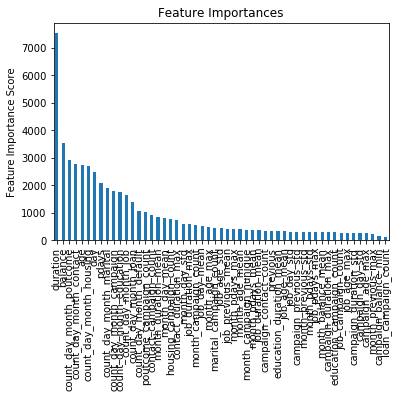

In [257]:
#降低learning_rate
xgb1 = XGBClassifier(learning_rate=0.01,
                     n_estimators=2000,
                     max_depth=5,
                     min_child_weight=6,
                     gamma=0,
                     subsample=0.85,
                     colsample_bytree=0.8,
                     objective='binary:logistic',
                     nthread=4,
                     scale_pos_weight=1,
                     seed=27)
# 得到Best Num Of Tree
modelfit(xgb1, x_train, y_train)

In [254]:
xgb1 = XGBClassifier(learning_rate=0.01,
                     n_estimators=1489,
                     max_depth=5,
                     min_child_weight=6,
                     gamma=0,
                     subsample=0.8,
                     colsample_bytree=0.85,
                     objective='binary:logistic',
                     nthread=4,
                     scale_pos_weight=1,
                     seed=27)
xgb1.fit(train_set[chosen_columns], y_train)
# xgb1.score(x_test,y_test)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.85, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=6, missing=None, n_estimators=1489, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
              silent=None, subsample=0.8, verbosity=1)

In [257]:
# test_set = pd.read_csv("./test_set.csv")
# ID = test_set['ID']
# test_set = test_set.drop(columns="ID")

# def preprocess(dataset):
# #     dataset = dataset.replace("no",0)
# #     dataset = dataset.replace("yes",1)
# #     dataset = dataset.drop(["day","month","contact"],axis=1)
    
    
#     vec = DictVectorizer(sparse=False)
#     dataset = vec.fit_transform(dataset.to_dict(orient="record"))
#     dataset = pd.DataFrame(dataset)
#     dataset.columns = vec.feature_names_
    
#     dataset = preprocessing.scale(dataset)
#     dataset = pd.DataFrame(dataset,columns=vec.feature_names_)
#     return dataset
# data = preprocess(test_set)
# data

,age,balance,campaign,contact=cellular,contact=telephone,contact=unknown,day,default=no,default=yes,duration,...,month=may,month=nov,month=oct,month=sep,pdays,poutcome=failure,poutcome=other,poutcome=success,poutcome=unknown,previous
0,0.934987,-0.367399,0.074962,-1.360620,3.825819,-0.634088,1.604427,0.135974,-0.135974,0.202795,...,-0.661325,-0.309385,-0.133135,-0.108384,-0.411525,-0.353095,-0.196894,-0.187089,0.471683,-0.302595
1,-0.848737,1.406076,-0.251479,0.734959,-0.261382,-0.634088,0.520342,0.135974,-0.135974,-0.587721,...,-0.661325,3.232222,-0.133135,-0.108384,-0.411525,-0.353095,-0.196894,-0.187089,0.471683,-0.302595
2,1.779908,-0.419835,0.074962,-1.360620,3.825819,-0.634088,1.724881,0.135974,-0.135974,-0.507871,...,-0.661325,-0.309385,-0.133135,-0.108384,-0.411525,-0.353095,-0.196894,-0.187089,0.471683,-0.302595
3,-0.848737,-0.400548,0.401403,0.734959,-0.261382,-0.634088,1.724881,0.135974,-0.135974,1.360621,...,-0.661325,-0.309385,-0.133135,-0.108384,0.653593,2.832098,-0.196894,-0.187089,-2.120067,2.466176
4,-0.003815,-0.419835,0.401403,0.734959,-0.261382,-0.634088,-0.081927,0.135974,-0.135974,0.442345,...,-0.661325,-0.309385,-0.133135,-0.108384,-0.411525,-0.353095,-0.196894,-0.187089,0.471683,-0.302595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10847,-1.130377,-0.403562,0.074962,-1.360620,-0.261382,1.577069,1.243066,0.135974,-0.135974,-0.000823,...,1.512115,-0.309385,-0.133135,-0.108384,-0.411525,-0.353095,-0.196894,-0.187089,0.471683,-0.302595
10848,-0.567096,-0.216722,-0.251479,0.734959,-0.261382,-0.634088,-0.925104,0.135974,-0.135974,-0.679549,...,-0.661325,-0.309385,-0.133135,-0.108384,-0.411525,-0.353095,-0.196894,-0.187089,0.471683,-0.302595
10849,-0.285456,-0.288746,-0.251479,-1.360620,-0.261382,1.577069,0.881704,0.135974,-0.135974,-0.256343,...,1.512115,-0.309385,-0.133135,-0.108384,-0.411525,-0.353095,-0.196894,-0.187089,0.471683,-0.302595
10850,-0.003815,-0.183874,0.074962,0.734959,-0.261382,-0.634088,-0.202381,0.135974,-0.135974,-0.487909,...,1.512115,-0.309385,-0.133135,-0.108384,3.246051,2.832098,-0.196894,-0.187089,-2.120067,0.804913


In [255]:
predict = xgb1.predict_proba(test_set[chosen_columns])
# result.to_csv("re.csv")
sub = test_set[["ID"]].copy()
# sub.insert(0,'pred',result)
sub.insert(1,"pred",predict[:,1])
sub
sub.to_csv("result.csv",index=False)


,ID,pred
25317,25318,0.043742
25318,25319,0.002471
25319,25320,0.005374
25320,25321,0.666385
25321,25322,0.021406
...,...,...
36164,36165,0.002593
36165,36166,0.002904
36166,36167,0.001467
36167,36168,0.003179
